In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import sys
import os
# Add the directory to sys.path
datasets_dir = '/dtu/blackhole/16/155094/Video_classification'
sys.path.append(datasets_dir)
from datasets import FrameImageDataset, FrameVideoDataset

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
batch_size = 40

# Dataset directories
root_dir = '/dtu/blackhole/16/155094/ufc101'

# Initialize datasets
train_dataset = FrameVideoDataset(root_dir=root_dir, split='train', transform=transform)
val_dataset = FrameVideoDataset(root_dir=root_dir, split='val', transform=transform)
test_dataset = FrameVideoDataset(root_dir=root_dir, split='test', transform=transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
class Simple_CNN(nn.Module):
    def __init__(self, dropOutVal=0.2, num_classes=10, input_channels = 3):
        super(Simple_CNN, self).__init__()

        # Convolutional Feature Extraction
        self.network = nn.Sequential(
            nn.Conv3d(input_channels, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(128),
            nn.MaxPool3d(2, 2),  

            nn.Dropout3d(dropOutVal),
            nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(256),
            nn.MaxPool3d(2, 2),  
            
            nn.Dropout3d(dropOutVal),
            nn.Conv3d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(128),
            
            nn.Dropout3d(dropOutVal),
            nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2, 2),  
        )
        # Classification Head
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(50176, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes) 
        )
        

    def forward(self, x):
        features = self.network(x).view(x.size(0), -1) # Flatten
        
        class_out = self.classifier(features)
        
        return class_out


    


In [10]:
# # Initialize the model

# model = Simple_CNN(input_channels =3, dropOutVal=0.4)
# model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)

# # Metrics storage
# train_loss_history = []
# val_loss_history = []
# train_acc_history = []
# val_acc_history = []

# Training and Validation Loop
epochs = 10
for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    

    for videos, labels in train_loader:
        
        videos, labels = videos.to(device), labels.to(device)
        # Forward pass
        outputs = model(videos)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for videos, labels in val_loader:

            videos, labels = videos.to(device), labels.to(device)

            outputs = model(videos)
            loss = criterion(outputs, labels)
            

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Print metrics
    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")


Epoch [1/10]
Train Loss: 0.4625, Train Accuracy: 85.60%
Val Loss: 0.8428, Val Accuracy: 79.17%
Epoch [2/10]
Train Loss: 0.3285, Train Accuracy: 90.20%
Val Loss: 1.0159, Val Accuracy: 75.83%
Epoch [3/10]
Train Loss: 0.2948, Train Accuracy: 90.60%
Val Loss: 0.8441, Val Accuracy: 77.50%
Epoch [4/10]
Train Loss: 0.2428, Train Accuracy: 92.20%
Val Loss: 0.6636, Val Accuracy: 81.67%
Epoch [5/10]
Train Loss: 0.1865, Train Accuracy: 95.20%
Val Loss: 0.6602, Val Accuracy: 81.67%
Epoch [6/10]
Train Loss: 0.1870, Train Accuracy: 94.40%
Val Loss: 0.5743, Val Accuracy: 85.83%
Epoch [7/10]
Train Loss: 0.1906, Train Accuracy: 93.80%
Val Loss: 0.7804, Val Accuracy: 77.50%
Epoch [8/10]
Train Loss: 0.1926, Train Accuracy: 94.60%
Val Loss: 0.7983, Val Accuracy: 80.83%
Epoch [9/10]
Train Loss: 0.1980, Train Accuracy: 93.40%
Val Loss: 0.7111, Val Accuracy: 80.83%
Epoch [10/10]
Train Loss: 0.2016, Train Accuracy: 94.80%
Val Loss: 0.6660, Val Accuracy: 83.33%


In [11]:
torch.save(model, "3D_simpleCNN.pkl")
file = open("3D_simpleCNN.pkl", "rb")
model = torch.load(file)

/tmp/ipykernel_1376283/3231151388.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(file)


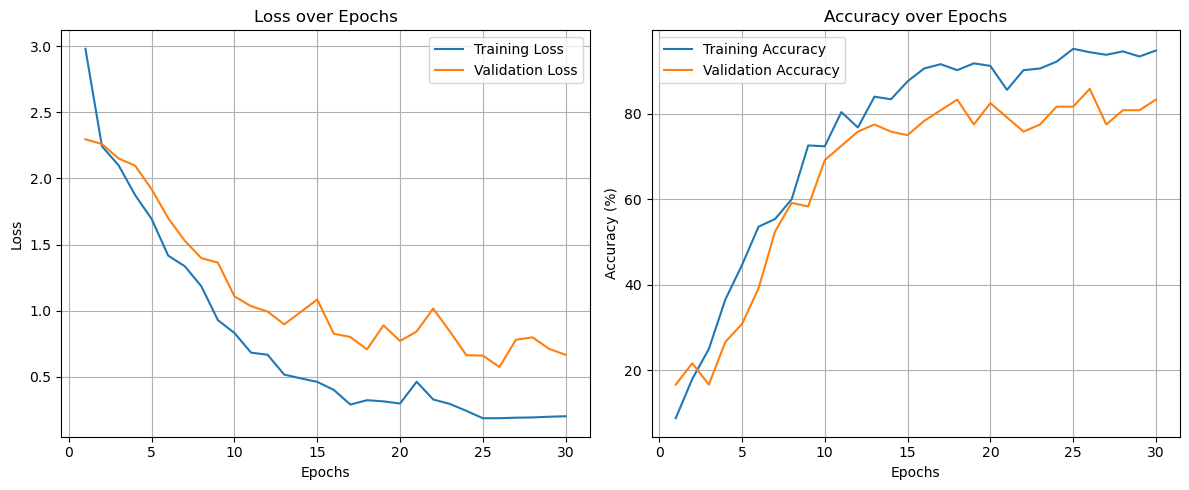

In [12]:
# Plotting Loss over Epochs
epochs_range = range(1, len(train_loss_history) +1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Validation
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for videos, labels in test_loader:

        videos, labels = videos.to(device), labels.to(device)

        outputs = model(videos)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

val_loss /= len(val_loader)
val_acc = 100 * correct / total


# Print metrics
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.2f}%")

Test Loss: 0.5006, Test Accuracy: 86.67%
